## 0. Import dependencies

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sys
sys.path.insert(0, '../utils')
from load_data import ames_housing
from preprocess_data import cat2int

import functools
import tensorflow as tf
from tensorflow.python.feature_column.feature_column import _LazyBuilder
tf.__version__

'1.9.0'

## 1. Load data

In [2]:
dirfolder = '../data/Ames-Housing'
numvalid = 100
(traindf, trainy), (validdf, validy), testdf = ames_housing(dirfolder, numvalid)

../utils/load_data.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  testdf_new['Id'] = test_ID


## 2. Preprocess input data

In [3]:
trainX = traindf.values
validX = validdf.values
testX = testdf.values

# normalization
max_val = np.max(trainX, axis=0)
min_val = np.min(trainX, axis=0)
for i in range(trainX.shape[1]):
    if max_val[i] != 0:
        trainX[:, i] = (trainX[:, i]-min_val[i])/(max_val[i]-min_val[i])
        validX[:, i] = (validX[:, i]-min_val[i])/(max_val[i]-min_val[i])
        testX[:, i] = (testX[:, i]-min_val[i])/(max_val[i]-min_val[i])

## 3. Create dataflow graphs

In [5]:
# hyperparameters
lr_decay = 1.0
lr_0 = 1.0
batch_size = 32
iterations = 500000
monitor = 10000
perf_reduce = 0.2
keep_prob_input_0 = 0.8

# network size
num_train, num_in = trainX.shape
num_out = 1

# create network graph
x = tf.placeholder(tf.float32, [None, num_in])
keep_prob_input = tf.placeholder(tf.float32)
x_drop = tf.nn.dropout(x, keep_prob_input)
W = tf.Variable(tf.random_normal([num_in, num_out], stddev=0.1))
b = tf.Variable(tf.random_normal([num_out], stddev=0.1))
y = tf.matmul(x_drop, W) + b

# create training graph
learning_rate = tf.placeholder(tf.float32)
y_ = tf.placeholder(tf.float32, [None, num_out])
cost = tf.losses.mean_squared_error(y_, y)
train = tf.train.AdadeltaOptimizer(learning_rate).minimize(cost)

## 4. Training

In [6]:
# initialize
session = tf.Session()
session.run(tf.global_variables_initializer())

# train
start = 0
last_perf_train = np.inf
last_perf_valid = np.inf
best_perf_valid = np.inf
saver = tf.train.Saver()
for i in range(iterations):
    session.run(train, feed_dict={x: trainX[start:start+batch_size, :], 
                                  y_: trainy[start:start+batch_size],
                                  keep_prob_input: keep_prob_input_0,
                                  learning_rate: lr_0})
    start += batch_size
    if start > num_train-batch_size: 
        start = 0
    if i % monitor == 0:
        perf_train = session.run(cost, feed_dict={x: trainX, 
                                                  y_: trainy,
                                                  keep_prob_input: 1.0})
        perf_valid = session.run(cost, feed_dict={x: validX, 
                                                  y_: validy, 
                                                  keep_prob_input: 1.0})
        print("{}: {}, {}".format(i, perf_train, perf_valid))
        if ((perf_valid-best_perf_valid)/best_perf_valid > perf_reduce):
            print("Performance degrades extremely. Training stops.")
            break
        last_perf_train = perf_train
        last_perf_valid = perf_valid
        if perf_valid < best_perf_valid:
            save_path = saver.save(session, "model/linreg_model.ckpt")
            print("Better model has been saved.")
            best_perf_valid = perf_valid
        lr_0 = lr_0*lr_decay
session.close()

0: 123.11971282958984, 122.425048828125
Better model has been saved.


/home/ymtoo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars


10000: 0.08733315765857697, 0.08983362466096878
Better model has been saved.
20000: 0.057945188134908676, 0.0627138540148735
Better model has been saved.
30000: 0.04581534489989281, 0.04891880974173546
Better model has been saved.
40000: 0.040464483201503754, 0.043077755719423294
Better model has been saved.
50000: 0.028856422752141953, 0.030361618846654892
Better model has been saved.
60000: 0.022167278453707695, 0.02464192546904087
Better model has been saved.
70000: 0.01877133920788765, 0.020458491519093513
Better model has been saved.
80000: 0.01663251966238022, 0.01887686364352703
Better model has been saved.
90000: 0.015722578391432762, 0.018534021452069283
Better model has been saved.
100000: 0.015396958217024803, 0.018522443249821663
Better model has been saved.
110000: 0.015505914576351643, 0.018591485917568207
120000: 0.01592923328280449, 0.01985819637775421
130000: 0.015457844361662865, 0.01928752474486828
140000: 0.015697868540883064, 0.019195737317204475
150000: 0.01541452

## 5. Predict

In [7]:
session = tf.Session()
saver.restore(session, 'model/linreg_model.ckpt')
perf_train = session.run(cost, feed_dict={x: trainX, 
                                          y_: trainy,
                                          keep_prob_input: 1.0})
perf_valid = session.run(cost, feed_dict={x: validX, 
                                          y_: validy, 
                                          keep_prob_input: 1.0})
print(perf_train, perf_valid)
predtrainy = session.run(y, feed_dict={x: trainX,
                                       keep_prob_input: 1.0})
predvalidy = session.run(y, feed_dict={x: validX, 
                                       keep_prob_input: 1.0})
predtesty = session.run(y, feed_dict={x: testX, 
                                      keep_prob_input: 1.0})
session.close()

INFO:tensorflow:Restoring parameters from model/linreg_model.ckpt
0.015397 0.0185224


## 6. Plot results

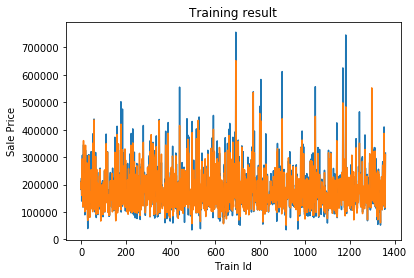

In [8]:
fig, ax = plt.subplots()
ax.plot(np.expm1(trainy), label='True')
ax.plot(np.expm1(predtrainy), label='Predict')
ax.set_xlabel('Train Id')
ax.set_ylabel('Sale Price')
ax.set_title('Training result');

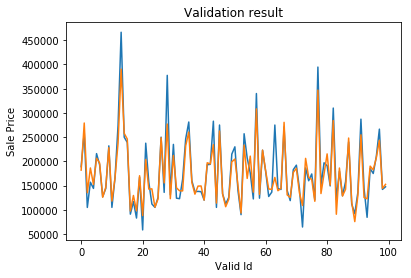

In [9]:
fig, ax = plt.subplots()
ax.plot(np.expm1(validy), label='True')
ax.plot(np.expm1(predvalidy), label='Predict')
ax.set_xlabel('Valid Id')
ax.set_ylabel('Sale Price')
ax.set_title('Validation result');

## 7. Save testing result for submission

In [11]:
sub_dict = {'Id': testdf.index.tolist(), 'SalePrice': np.expm1(predtesty).flatten()}
linreg_submission = pd.DataFrame(sub_dict)
linreg_submission.set_index('Id', inplace=True)
linreg_submission.to_csv('linreg_submission')